In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
plt.ion()  # Enable interactive mode

In [3]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [4]:
df=pd.read_csv('solar_pv_data.csv', delimiter=',')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (196776, 17)


,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0000,1.6000,1021,100,4.9000,0.0000,0.0000,100,0,0,450,0.0000,4,0,1
1,2017-01-01 00:15:00,0,0.0000,1.6000,1021,100,4.9000,0.0000,0.0000,100,0,0,450,0.0000,4,0,1
2,2017-01-01 00:30:00,0,0.0000,1.6000,1021,100,4.9000,0.0000,0.0000,100,0,0,450,0.0000,4,0,1
3,2017-01-01 00:45:00,0,0.0000,1.6000,1021,100,4.9000,0.0000,0.0000,100,0,0,450,0.0000,4,0,1
4,2017-01-01 01:00:00,0,0.0000,1.7000,1020,100,5.2000,0.0000,0.0000,100,0,0,450,0.0000,4,1,1


In [5]:
df1=pd.read_excel('Report_2022-2023.xlsx', sheet_name='Data', skiprows=10, header=0)
df2=pd.read_excel('Report_2023-2024.xlsx', sheet_name='Data', skiprows=10, header=0)

print('Number of rows and columns:', df1.shape)
print('Number of rows and columns:', df2.shape)

#df1.head()
df2.head()

Number of rows and columns: (17568, 31)
Number of rows and columns: (17472, 31)


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,2023-07-22 00:00:00,0.0000,5.9890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,0.0000,5.7550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,0.0000,6.2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,0.0000,5.7580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,0.0000,6.0340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df1_cleaned = df1.dropna(axis=1, how='all')
print('No of rows and columns:', df1_cleaned.shape)
df1_reduced = df1.iloc[:, :3]
df1_renamed = df1_reduced.rename(columns={'Unnamed: 0': 'date_time', 'day': 'day (kWh)', 'night': 'night (kWh)'})
df1_renamed.head()

No of rows and columns: (17568, 8)


,date_time,day (kWh),night (kWh)
0,2022-07-21 00:00:00,0.0000,5.3450
1,,0.0000,5.5350
2,,0.0000,5.6630
3,,0.0000,5.4640
4,,0.0000,5.4140


In [7]:
df2_cleaned = df2.dropna(axis=1, how='all')
print('No of rows and columns:', df2_cleaned.shape)
df2_reduced = df2.iloc[:, :3]
df2_renamed = df2_reduced.rename(columns={'Unnamed: 0': 'date_time', 'Unnamed: 1': 'day (kWh)', 'Unnamed: 2': 'night (kWh)'})
df2_renamed.head()

No of rows and columns: (17472, 7)


,date_time,day (kWh),night (kWh)
0,2023-07-22 00:00:00,0.0000,5.9890
1,,0.0000,5.7550
2,,0.0000,6.2000
3,,0.0000,5.7580
4,,0.0000,6.0340


In [8]:
start_datetime = pd.Timestamp('2022-07-21 00:00:00')
increments = pd.to_timedelta([i * 30 for i in range(len(df1_renamed))], unit='m')

# Create the new 'date_time' column
df1_renamed['date_time'] = start_datetime + increments

print(df1_renamed['date_time'].shape)
df1_renamed.head()

(17568,)


,date_time,day (kWh),night (kWh)
0,2022-07-21 00:00:00,0.0000,5.3450
1,2022-07-21 00:30:00,0.0000,5.5350
2,2022-07-21 01:00:00,0.0000,5.6630
3,2022-07-21 01:30:00,0.0000,5.4640
4,2022-07-21 02:00:00,0.0000,5.4140


In [9]:
start_datetime = pd.Timestamp('2023-07-22 00:00:00')
increments = pd.to_timedelta([i * 30 for i in range(len(df2_renamed))], unit='m')

# Create the new 'date_time' column
df2_renamed['date_time'] = start_datetime + increments

print(df2_renamed['date_time'].shape)
df2_renamed.head()

(17472,)


,date_time,day (kWh),night (kWh)
0,2023-07-22 00:00:00,0.0000,5.9890
1,2023-07-22 00:30:00,0.0000,5.7550
2,2023-07-22 01:00:00,0.0000,6.2000
3,2023-07-22 01:30:00,0.0000,5.7580
4,2023-07-22 02:00:00,0.0000,6.0340


In [10]:
# Create the new 'date_time' column
df1_renamed['total'] = df1_renamed['day (kWh)'] + df1_renamed['night (kWh)']
df1_renamed.head()

,date_time,day (kWh),night (kWh),total
0,2022-07-21 00:00:00,0.0000,5.3450,5.3450
1,2022-07-21 00:30:00,0.0000,5.5350,5.5350
2,2022-07-21 01:00:00,0.0000,5.6630,5.6630
3,2022-07-21 01:30:00,0.0000,5.4640,5.4640
4,2022-07-21 02:00:00,0.0000,5.4140,5.4140


In [11]:
# Create the new 'date_time' column
df2_renamed['total'] = df2_renamed['day (kWh)'] + df2_renamed['night (kWh)']
df2_renamed.head()

,date_time,day (kWh),night (kWh),total
0,2023-07-22 00:00:00,0.0000,5.9890,5.9890
1,2023-07-22 00:30:00,0.0000,5.7550,5.7550
2,2023-07-22 01:00:00,0.0000,6.2000,6.2000
3,2023-07-22 01:30:00,0.0000,5.7580,5.7580
4,2023-07-22 02:00:00,0.0000,6.0340,6.0340


In [12]:
# Concatenate vertically
combined_df = pd.concat([df1_renamed, df2_renamed], axis=0, ignore_index=True)
print(combined_df)

                date_time  day (kWh)  night (kWh)  total
0     2022-07-21 00:00:00     0.0000       5.3450 5.3450
1     2022-07-21 00:30:00     0.0000       5.5350 5.5350
2     2022-07-21 01:00:00     0.0000       5.6630 5.6630
3     2022-07-21 01:30:00     0.0000       5.4640 5.4640
4     2022-07-21 02:00:00     0.0000       5.4140 5.4140
...                   ...        ...          ...    ...
35035 2024-07-19 21:30:00     0.0000       0.0000 0.0000
35036 2024-07-19 22:00:00     0.0000       0.0000 0.0000
35037 2024-07-19 22:30:00     0.0000       0.0000 0.0000
35038 2024-07-19 23:00:00     0.0000       0.0000 0.0000
35039 2024-07-19 23:30:00     0.0000       0.0000 0.0000

[35040 rows x 4 columns]


In [13]:
# Define the start and end dates for the two-month period
start_date = '2023-02-01'
end_date = '2024-02-28'

# Filter the DataFrame for the desired date range
filtered_df = combined_df[(combined_df['date_time'] >= start_date) & (combined_df['date_time'] <= end_date)]

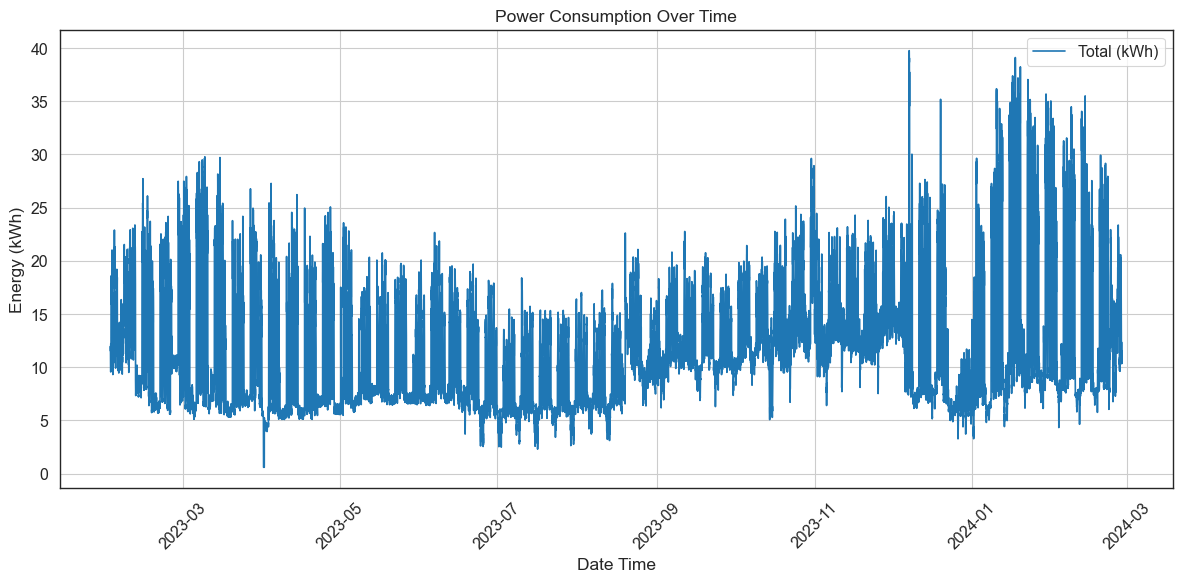

In [14]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each column
#plt.plot(filtered_df['date_time'], filtered_df['day (kW)'], label='Day (kW)', marker='o')
#plt.plot(combined_df['date_time'], combined_df['night (kW)'], label='Night (kW)', marker='o')
plt.plot(filtered_df['date_time'], filtered_df['total'], label='Total (kWh)')

# Formatting
plt.xlabel('Date Time')
plt.ylabel('Energy (kWh)')
plt.title('Power Consumption Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show plot
plt.tight_layout()
plt.show()


In [15]:
combined_df.head()

,date_time,day (kWh),night (kWh),total
0,2022-07-21 00:00:00,0.0000,5.3450,5.3450
1,2022-07-21 00:30:00,0.0000,5.5350,5.5350
2,2022-07-21 01:00:00,0.0000,5.6630,5.6630
3,2022-07-21 01:30:00,0.0000,5.4640,5.4640
4,2022-07-21 02:00:00,0.0000,5.4140,5.4140


In [16]:
combined_df['year'] = combined_df['date_time'].apply(lambda x: x.year)
combined_df['quarter'] = combined_df['date_time'].apply(lambda x: x.quarter)
combined_df['month'] = combined_df['date_time'].apply(lambda x: x.month)
combined_df['day'] = combined_df['date_time'].apply(lambda x: x.day)
combined_df=combined_df.loc[:,['date_time','total', 'year','quarter','month','day']]
combined_df.sort_values('date_time', inplace=True, ascending=True)
combined_df = combined_df.reset_index(drop=True)
combined_df["weekday"]=combined_df.apply(lambda row: row["date_time"].weekday(),axis=1)
combined_df["weekday"] = (combined_df["weekday"] < 5).astype(int)
print(combined_df.shape)
print(combined_df.date_time.min())
print(combined_df.date_time.max())
combined_df.tail(5)

(35040, 7)
2022-07-21 00:00:00
2024-07-19 23:30:00


,date_time,total,year,quarter,month,day,weekday
35035,2024-07-19 21:30:00,0.0000,2024,3,7,19,1
35036,2024-07-19 22:00:00,0.0000,2024,3,7,19,1
35037,2024-07-19 22:30:00,0.0000,2024,3,7,19,1
35038,2024-07-19 23:00:00,0.0000,2024,3,7,19,1
35039,2024-07-19 23:30:00,0.0000,2024,3,7,19,1


In [17]:
print('Number of rows and columns after removing missing values:', combined_df.shape)
print('The time series starts from: ', combined_df.date_time.min())
print('The time series ends on: ', combined_df.date_time.max())

Number of rows and columns after removing missing values: (35040, 7)
The time series starts from:  2022-07-21 00:00:00
The time series ends on:  2024-07-19 23:30:00


In [18]:
#Statistical Normality Test
#D'Agostino's K^2 test

stat, p = stats.normaltest(combined_df.total)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics=5293.267, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 0.9945043181574347
Skewness of normal distribution: 1.0756785871814387


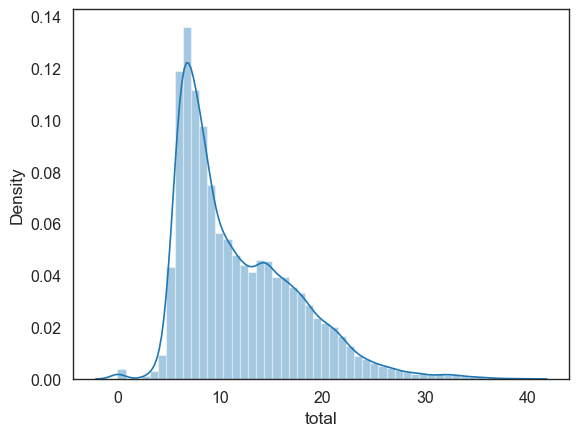

In [19]:
# Kurtosis & Skewness

sns.distplot(combined_df.total);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(combined_df.total)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(combined_df.total)))

**Kurtosis**:
Kurtosis describes heaviness of the tail distribution
Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails.
If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

**SKEWNESS**:
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1,
the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.


# Box plot of yearly vs. quarterly total energy

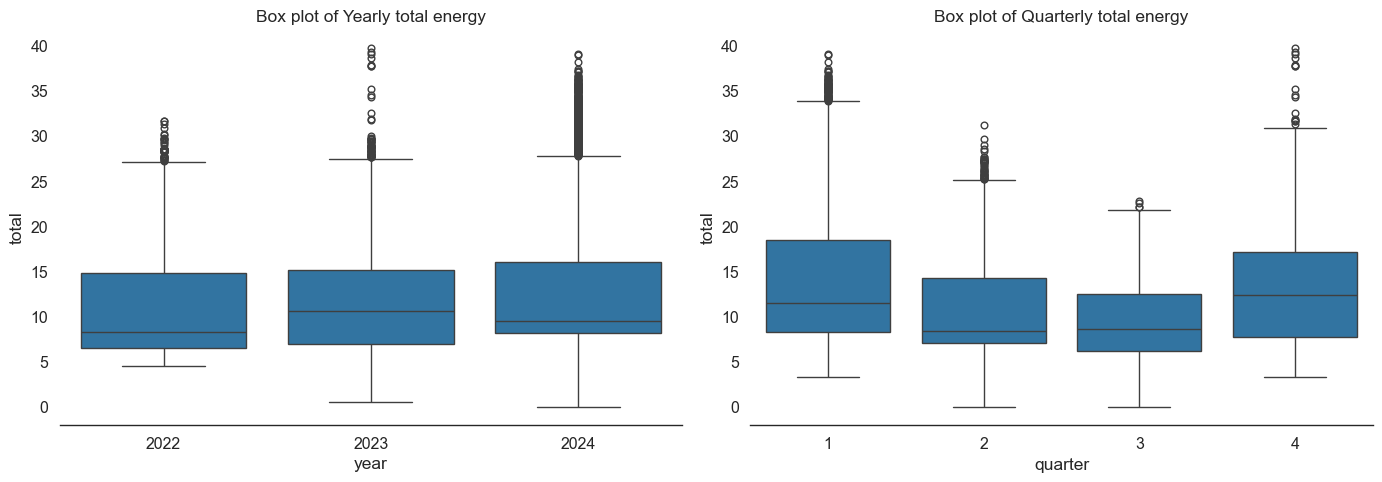

In [20]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="total", data=combined_df)
plt.xlabel('year')
plt.title('Box plot of Yearly total energy')
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="total", data=combined_df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly total energy')
sns.despine(left=True)
plt.tight_layout();

# Total energy distribution

,count,mean,min,25%,50%,75%,max,std
date_time,35040,2023-07-20 23:45:00,2022-07-21 00:00:00,2023-01-19 11:52:30,2023-07-20 23:45:00,2024-01-19 11:37:30,2024-07-19 23:30:00,NaN
total,35040.0000,11.6935,0.0000,7.1510,9.9510,15.2683,39.7570,5.6961
year,35040.0000,2023.0507,2022.0000,2023.0000,2023.0000,2024.0000,2024.0000,0.7053
quarter,35040.0000,2.5068,1.0000,2.0000,3.0000,4.0000,4.0000,1.1180
month,35040.0000,6.5192,1.0000,4.0000,7.0000,10.0000,12.0000,3.4519
day,35040.0000,15.7329,1.0000,8.0000,16.0000,23.0000,31.0000,8.8087
weekday,35040.0000,0.7151,0.0000,0.0000,1.0000,1.0000,1.0000,0.4514


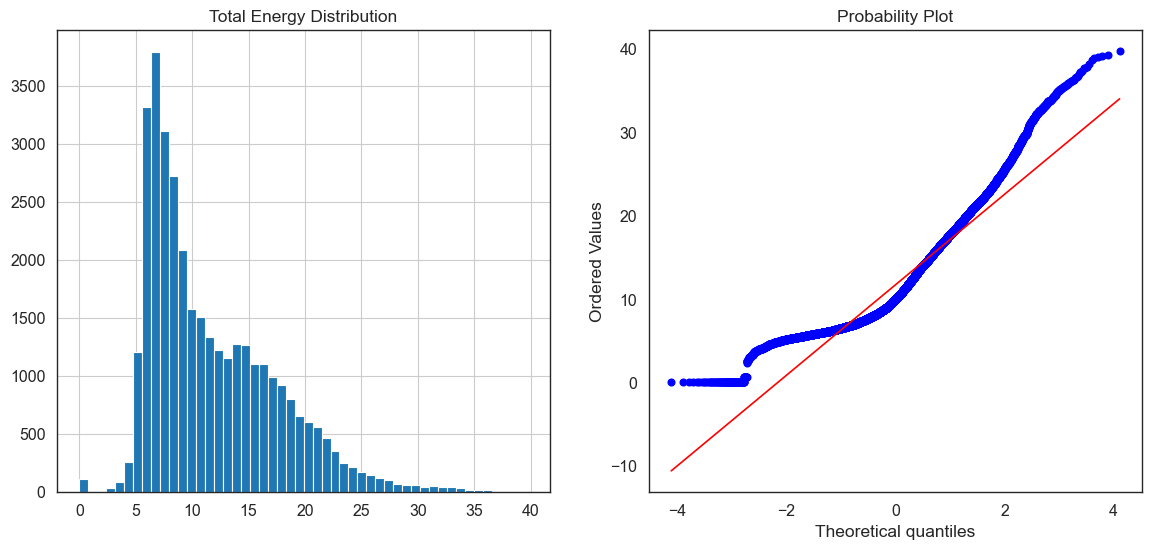

In [21]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
combined_df['total'].hist(bins=50)
plt.title('Total Energy Distribution')

plt.subplot(1,2,2)
stats.probplot(combined_df['total'], plot=plt);
combined_df.describe().T

# Total energy resampled over day, week, month, quarter and year.

In [22]:
combined_df.head()

,date_time,total,year,quarter,month,day,weekday
0,2022-07-21 00:00:00,5.3450,2022,3,7,21,1
1,2022-07-21 00:30:00,5.5350,2022,3,7,21,1
2,2022-07-21 01:00:00,5.6630,2022,3,7,21,1
3,2022-07-21 01:30:00,5.4640,2022,3,7,21,1
4,2022-07-21 02:00:00,5.4140,2022,3,7,21,1


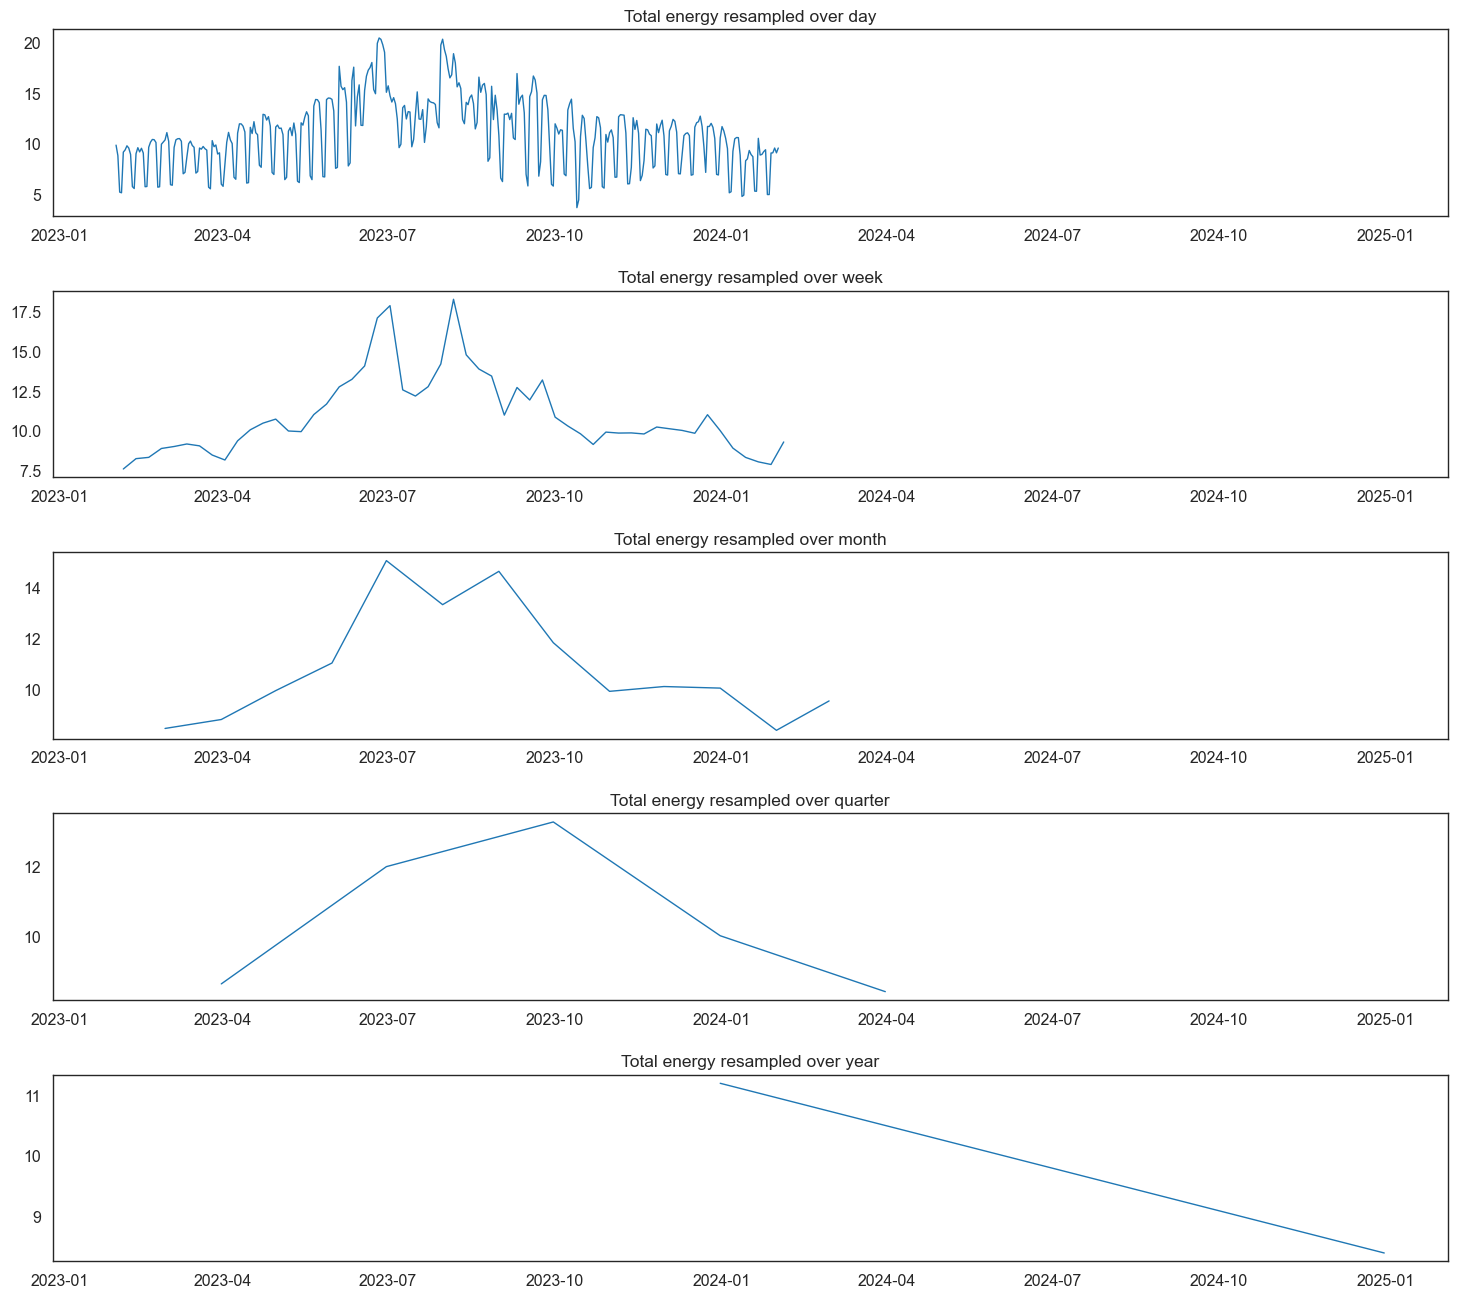

In [23]:
# Create a DatetimeIndex with 30-minute frequency
date_time_index = pd.date_range(start=start_date, periods=len(df1_renamed), freq='30T')

df1_renamed.index = pd.DatetimeIndex(date_time_index)
df1_renamed.index.name = 'date_time'

# Assuming total energy is the sum of 'day (kWh)' and 'night (kWh)'
df1_renamed['total'] = df1_renamed['day (kWh)'] + df1_renamed['night (kWh)']

# Plotting
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

# Daily resampling
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1_renamed['total'].resample('D').mean(), linewidth=1)
ax1.set_title('Total energy resampled over day')
ax1.tick_params(axis='both', which='major')

# Weekly resampling
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1_renamed['total'].resample('W').mean(), linewidth=1)
ax2.set_title('Total energy resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1_renamed['total'].resample('M').mean(),linewidth=1)
ax3.set_title('Total energy resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1_renamed['total'].resample('Q').mean(),linewidth=1)
ax4.set_title('Total energy resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1_renamed['total'].resample('A').mean(),linewidth=1)
ax5.set_title('Total energy resampled over year')
ax5.tick_params(axis='both', which='major');

plt.show()

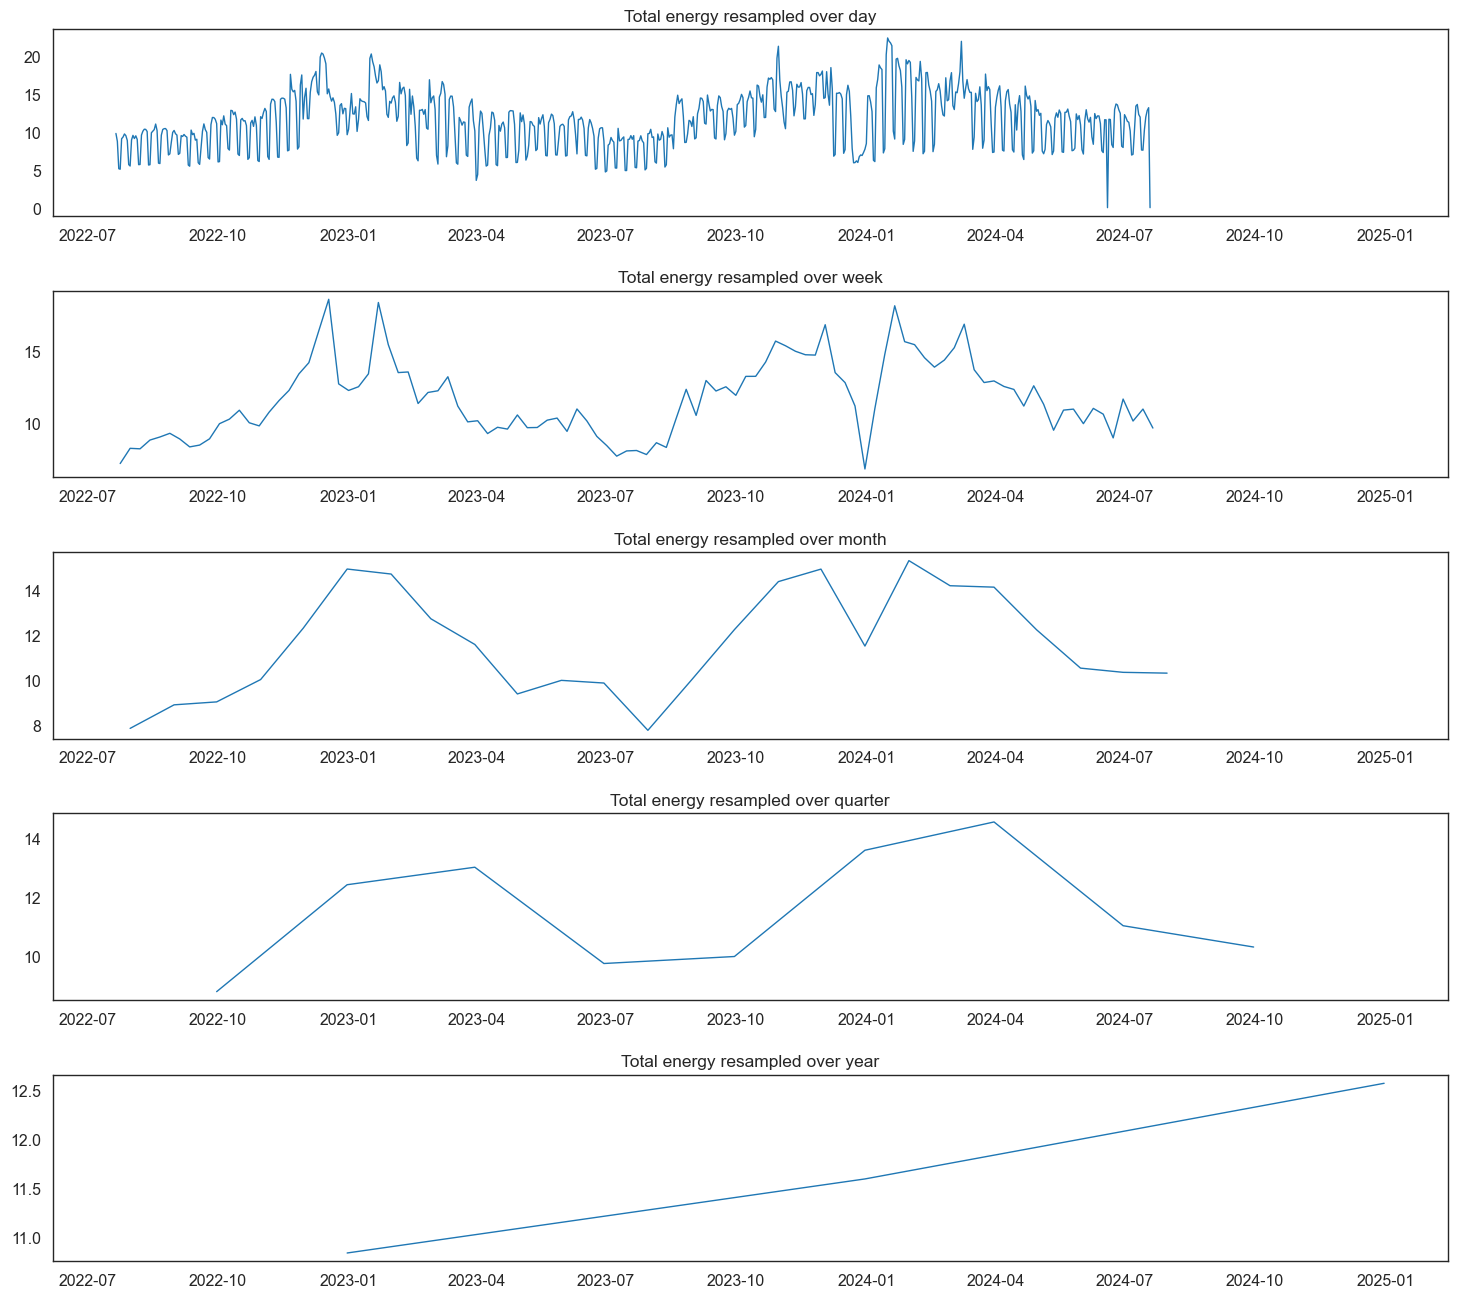

In [49]:
# Define the start date and time
start_date = "2022-07-21 00:00:00"

# Create a DatetimeIndex with 30-minute frequency
date_time_index = pd.date_range(start=start_date, periods=len(combined_df), freq='30T')

combined_df.index = pd.DatetimeIndex(date_time_index)
combined_df.index.name = 'date_time'

# Plotting
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

# Daily resampling
ax1 = fig.add_subplot(5,1,1)
ax1.plot(combined_df['total'].resample('D').mean(), linewidth=1)
ax1.set_title('Total energy resampled over day')
ax1.tick_params(axis='both', which='major')

# Weekly resampling
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(combined_df['total'].resample('W').mean(), linewidth=1)
ax2.set_title('Total energy resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(combined_df['total'].resample('M').mean(),linewidth=1)
ax3.set_title('Total energy resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(combined_df['total'].resample('Q').mean(),linewidth=1)
ax4.set_title('Total energy resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(combined_df['total'].resample('A').mean(),linewidth=1)
ax5.set_title('Total energy resampled over year')
ax5.tick_params(axis='both', which='major');

plt.show()

In [25]:
combined_df.tail()

,date_time,total,year,quarter,month,day,weekday
date_time,,,,,,,
2024-07-19 21:30:00,2024-07-19 21:30:00,0.0000,2024,3,7,19,1
2024-07-19 22:00:00,2024-07-19 22:00:00,0.0000,2024,3,7,19,1
2024-07-19 22:30:00,2024-07-19 22:30:00,0.0000,2024,3,7,19,1
2024-07-19 23:00:00,2024-07-19 23:00:00,0.0000,2024,3,7,19,1
2024-07-19 23:30:00,2024-07-19 23:30:00,0.0000,2024,3,7,19,1


# Dickey-Fuller Test to check Stationarity

The Dickey-Fuller test is useful in time series analysis for 
Stationarity Assessment: Many statistical models and methods assume that the time series data is stationary, meaning its statistical properties like mean, variance, and autocorrelation are constant over time. The Dickey-Fuller test helps assess if a series is stationary or if it has a unit root (which suggests non-stationarity).

Model Selection: In time series forecasting and modeling, such as with ARIMA (AutoRegressive Integrated Moving Average) models, ensuring the data is stationary is a fundamental step. The Dickey-Fuller test informs whether differencing or other transformations are needed to make the data stationary.

In [28]:
combined_df1=combined_df.resample('D').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

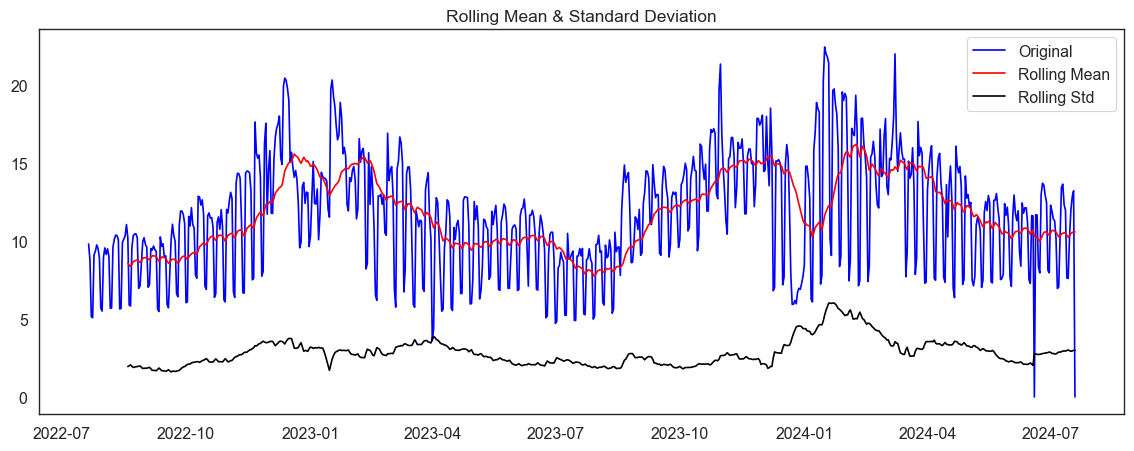

<Results of Dickey-Fuller Test>
Test Statistic                 -2.5727
p-value                         0.0988
#Lags Used                     20.0000
Number of Observations Used   709.0000
Critical Value (1%)            -3.4396
Critical Value (5%)            -2.8656
Critical Value (10%)           -2.5689
dtype: float64


In [29]:
test_stationarity(combined_df1.total.dropna())

The p-value is > 0.05, thus the series has a unit root and is non-stationary.

Non-stationary means statistical properties like mean, variance and autocorrelation are not constant over time. 
Shocks to the system do not dissipate (they have permanent effect).
This makes the forecasting more complex or unreliable becasue future values depend on unpredictable shocks.
Series models like ARIMA require stationarity. If a series is non-stationary due to a unit root, 
differencing (subtracting consecutive terms) is often used to make the series stationary before modeling.

# LSTM
If you want to reduce the computation time, and also get a quick result to test the model, you may want to resample the data over hour.
I will keep it  in minutes.

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix


In [55]:
dataset = combined_df.total.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [56]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [57]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [58]:
X_train.shape

(28001, 30)

In [59]:
Y_train.shape

(28001,)

In [60]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Model Architecture

In [61]:
X_train.shape

(28001, 1, 30)

In [63]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=50, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/50
401/401 [==============================] - 4s 4ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 2/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 3/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 7/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/50
401/401 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0019

In [64]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

219/219 [==============================] - 0s 1ms/step
Train Mean Absolute Error: 0.9857448339918893
Train Root Mean Squared Error: 1.644048535656659
Test Mean Absolute Error: 0.9241573602300293
Test Root Mean Squared Error: 1.6046956824689793


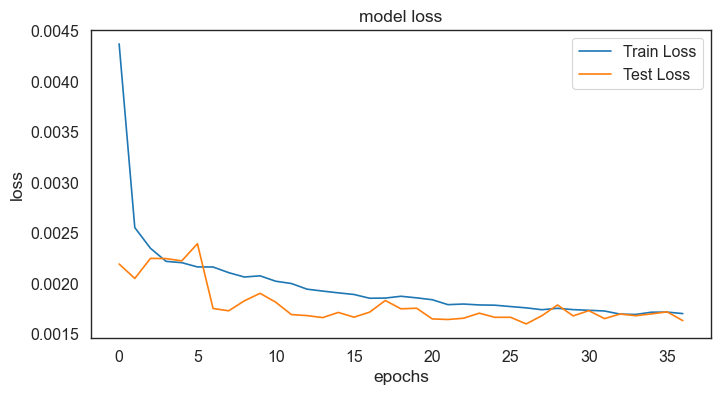

In [65]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

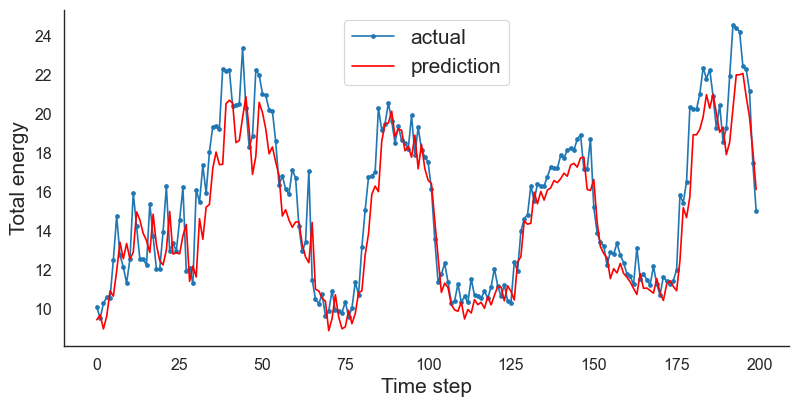

In [66]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Total energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [46]:
print(Y_test[:, 1:10])

[[ 9.52999983 10.30000071 10.61900051 10.5759999  12.54199941 14.7710003
  12.76799907 12.15699986 11.33600004]]


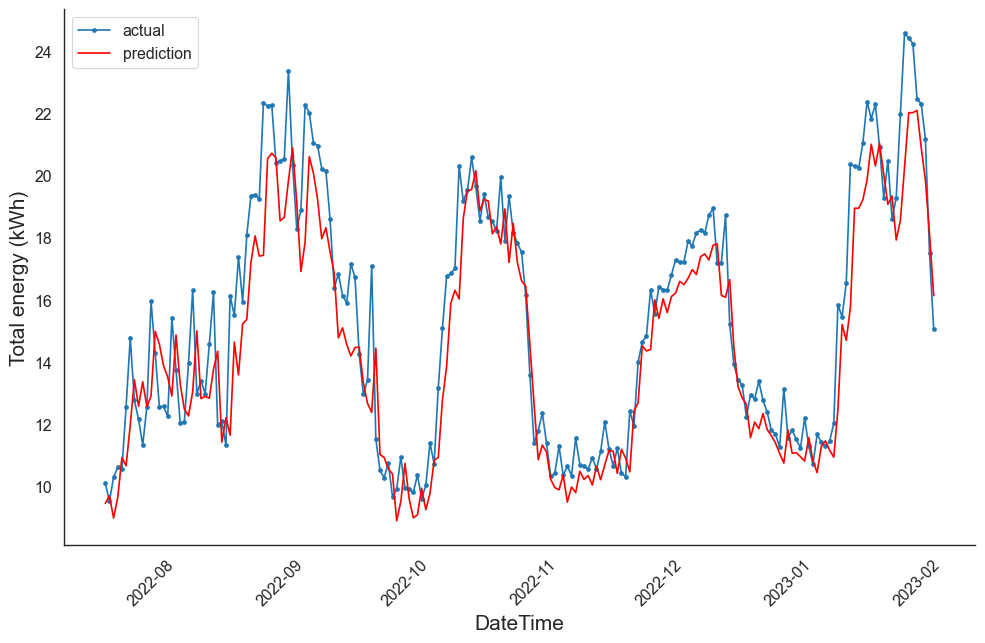

In [67]:
#start_date = "2022-07-21 00:00:00"

# Create a DatetimeIndex with 30-minute frequency
#date_time_index = pd.date_range(start=start_date, periods=len(combined_df), freq='30T')

# Example: Assuming the time series starts at '2022-01-01' and has a daily frequency
start_date = '2022-07-21'
date_time_index = pd.date_range(start=start_date, periods=200, freq='D')

plt.figure(figsize=(10, 6))

# Flattening or selecting the correct shape for Y_test and test_predict
Y_test_flat = Y_test.flatten()[:200]  # Flatten the array and take the first 200 elements
test_predict_flat = test_predict.flatten()[:200]  # Similarly flatten and slice the first 200 elements

# Plotting the actual values
plt.plot(date_time_index, Y_test_flat, marker='.', label="actual")

# Plotting the predicted values
plt.plot(date_time_index, test_predict_flat, 'r', label="prediction")

# Layout and aesthetics
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Total energy (kWh)', size=15)
plt.xlabel('DateTime', size=15)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

plt.show()
